## Imports and Setting Visualization Parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Set research-quality plotting parameters
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

## DATA INFRASTRUCTURE SETUP AND QUALITY ASSESSMENT

In [ ]:
df = pd.read_csv("C:\\Users\\Ashish Siwach\\OneDrive - University of Exeter\\Dissertation_Cld\\Datasets\\final_dataset.csv")
df.head()

,date,BEV_Registrations,Total_Vehicle_Registrations,BEV_Share,Charging_Infrastructure,RHDI_per_head,CPI,Petrol_Price,PiCG_Amount_GBP,GT_Index
0,2011-01-31,54,424100,0.000127,0,5129.0000,91.3,127.40,5000.0,-1.574771
1,2011-02-28,36,360400,0.000100,0,5088.0000,92.0,129.00,5000.0,-2.017975
2,2011-03-31,320,662000,0.000483,0,5047.0000,92.2,132.25,5000.0,-1.719808
3,2011-04-30,320,434400,0.000737,0,5063.3333,93.2,134.29,5000.0,-2.017975
4,2011-05-31,38,447300,0.000085,0,5079.6667,93.4,136.28,5000.0,-1.995205


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         162 non-null    object 
 1   BEV_Registrations            162 non-null    int64  
 2   Total_Vehicle_Registrations  162 non-null    int64  
 3   BEV_Share                    162 non-null    float64
 4   Charging_Infrastructure      162 non-null    int64  
 5   RHDI_per_head                162 non-null    float64
 6   CPI                          162 non-null    float64
 7   Petrol_Price                 162 non-null    float64
 8   PiCG_Amount_GBP              162 non-null    float64
 9   GT_Index                     162 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 12.8+ KB


## Outlier Analysis

Displaying Time Series Plot of BEV Registrations...


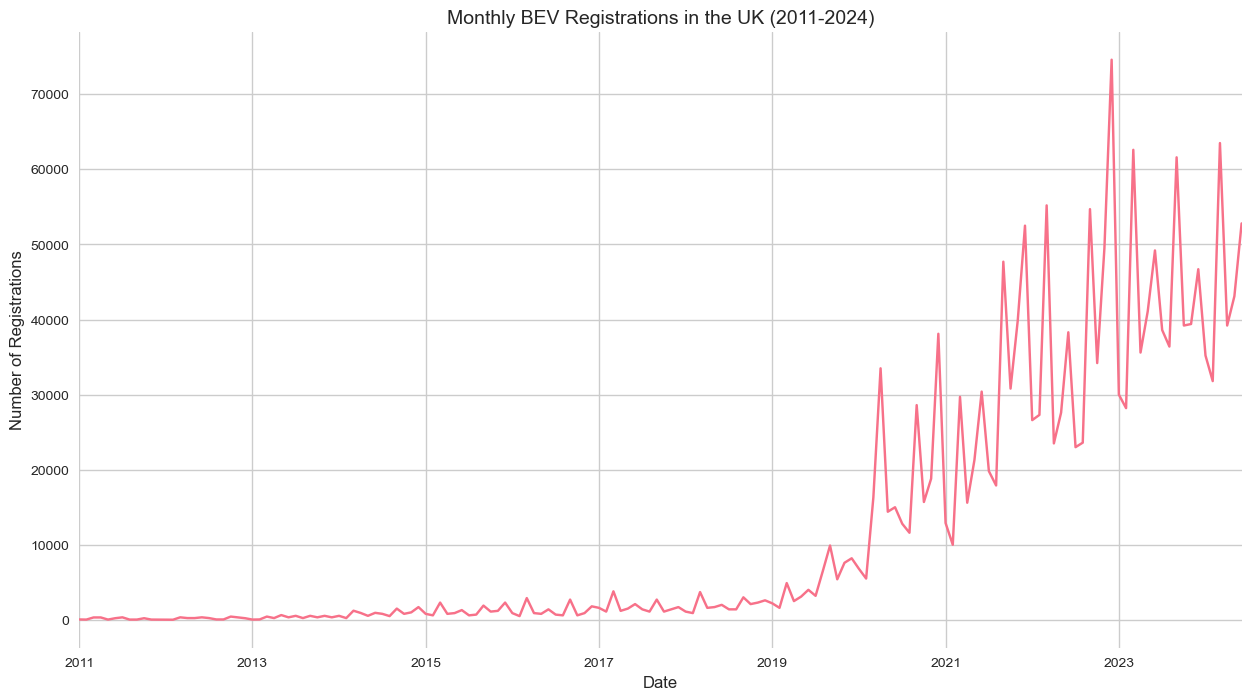


Displaying Box Plot of Registrations by Month...


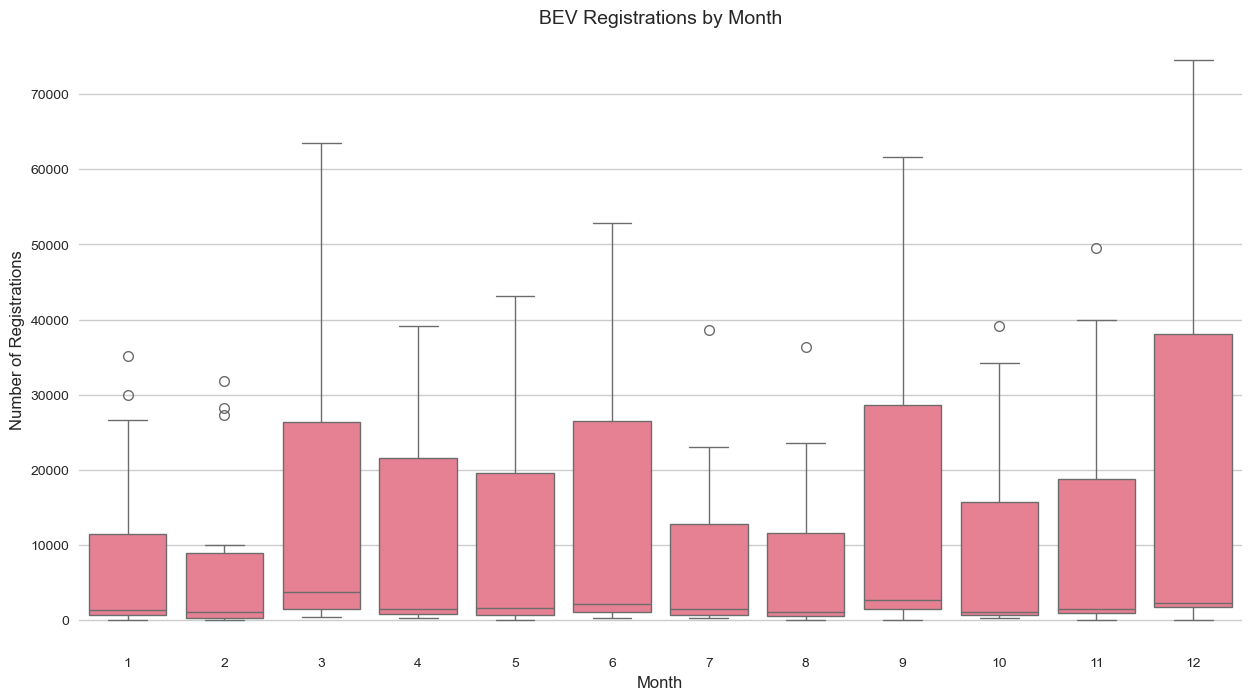

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (ensuring the date column is the index)
df = pd.read_csv("C:\\Users\\Ashish Siwach\\OneDrive - University of Exeter\\Dissertation_Cld\\Datasets\\final_dataset.csv", parse_dates=['date'], index_col='date')

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

# --- Plot 1: Time Series of BEV Registrations ---
# This plot helps us see outliers in the context of the overall trend.
print("Displaying Time Series Plot of BEV Registrations...")
ax = df['BEV_Registrations'].plot(title='Monthly BEV Registrations in the UK (2011-2024)')
ax.set_ylabel('Number of Registrations')
ax.set_xlabel('Date')
plt.show()

# --- Plot 2: Box Plot by Month ---
# This plot helps us see if certain months consistently have higher values or more variation.
# It's excellent for spotting seasonal outliers.
print("\nDisplaying Box Plot of Registrations by Month...")
fig, ax = plt.subplots()
sns.boxplot(x=df.index.month, y=df['BEV_Registrations'], ax=ax)
ax.set_title('BEV Registrations by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Registrations')
plt.show()

In [5]:
# Select the primary target variable for outlier detection
variable_to_check = 'BEV_Registrations'

# Calculate the first (Q1) and third (Q3) quartiles
Q1 = df[variable_to_check].quantile(0.25)
Q3 = df[variable_to_check].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and list the outliers
outliers = df[(df[variable_to_check] < lower_bound) | (df[variable_to_check] > upper_bound)]

print(f"--- Outlier Investigation for '{variable_to_check}' ---")
print(f"IQR: {IQR:.2f}, Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
print(f"Number of statistical outliers found: {len(outliers)}")
print("Outlier data points (Date and Value):")
print(outliers[[variable_to_check]])

--- Outlier Investigation for 'BEV_Registrations' ---
IQR: 18950.00, Lower Bound: -27825.00, Upper Bound: 47975.00
Number of statistical outliers found: 10
Outlier data points (Date and Value):
            BEV_Registrations
date                         
2021-12-31              52500
2022-03-31              55200
2022-09-30              54700
2022-11-30              49500
2022-12-31              74600
2023-03-31              62600
2023-06-30              49200
2023-09-30              61600
2024-03-31              63500
2024-06-30              52800


1. The lowest value possible for BEV Registrations is 0. Since the lower bound is well below 0 so indicator of outliers on the lower side.
2. However, from the box plot and the data points above the upper bound value clearly indicate presence of outliers on the higher side.
3. March and September outlier values coincide with the plate change month, so they can easily go up above the normal data points.
4. 31st December could be because of festive times.

**So, overall I don't feel any need for outlier treatment.**

## Creating Lagged Variables, Rolling Statistics Variables and Feature Interaction Variables
to capture recent and seasonal information as well as to provide additional information to ML models

In [ ]:
import pandas as pd

# Step 1: Load Data and Set Up
df = pd.read_csv("C:\\Users\\Ashish Siwach\\OneDrive - University of Exeter\\Dissertation_Cld\\Datasets\\final_dataset.csv", parse_dates=['date'], index_col='date')
print("Original dataset loaded. Shape:", df.shape)

# Step 2: Create Lag Features
print("\n--- Creating Lag Features ---")
features_to_lag = ['BEV_Registrations', 'BEV_Share', 'Charging_Infrastructure', 'RHDI_per_head', 'Petrol_Price', 'GT_Index']
lag_periods = [1, 3, 6, 12]
for feature in features_to_lag:
    for lag in lag_periods:
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

# Step 3: Create Rolling Features
print("\n--- Creating Rolling Features ---")
features_to_roll = ['BEV_Share', 'Petrol_Price', 'GT_Index']
window_sizes = [3, 6, 12]
for feature in features_to_roll:
    for window in window_sizes:
        df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=window).mean()
        df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=window).std()

# Step 4: Create Interaction Features
print("\n--- Creating Interaction Features ---")
df['FuelPrice_x_Policy'] = df['Petrol_Price_lag_1'] * df['PiCG_Amount_GBP']
df['Interest_x_Income'] = df['GT_Index_lag_1'] * df['RHDI_per_head_lag_1']

print(f"\nDataset shape after feature engineering: {df.shape}")
print(f"Number of missing values before imputation: {df.isnull().sum().sum()}")

# Step 5: Handle Missing Values
print("\n--- Step 5: Handling Missing Values ---")
# We use a robust two-step process:
# 1. Back-fill: Fills NaNs with the next valid value. Good for start-of-series NaNs.
df.bfill(inplace=True)
# 2. Forward-fill: Fills any remaining NaNs (e.g., at the end of the series).
df.ffill(inplace=True)

print(f"Number of missing values after imputation: {df.isnull().sum().sum()}")


# Step 6: Finalize and Save
print("\n--- Finalizing and Saving Dataset ---")
# Verify that all columns are now complete
print("\nData Info after cleaning:")
df.info()

# Save the enhanced and imputed dataset to a new file
df.to_csv('enhanced_imputed_dataset.csv')

print("\nEnhanced and imputed dataset saved to 'enhanced_imputed_dataset.csv' successfully.")

Original dataset loaded. Shape: (162, 9)

--- Creating Lag Features ---

--- Creating Rolling Features ---

--- Creating Interaction Features ---

Dataset shape after feature engineering: (162, 53)
Number of missing values before imputation: 242

--- Step 5: Handling Missing Values ---
Number of missing values after imputation: 0

--- Finalizing and Saving Dataset ---

Data Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162 entries, 2011-01-31 to 2024-06-30
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BEV_Registrations               162 non-null    int64  
 1   Total_Vehicle_Registrations     162 non-null    int64  
 2   BEV_Share                       162 non-null    float64
 3   Charging_Infrastructure         162 non-null    int64  
 4   RHDI_per_head                   162 non-null    float64
 5   CPI                             162 non-null  